# 26.2.2. Ultimate Tech take home challenge

**Table of contents**<a id='toc0_'></a>    
- [Import modules and data](#toc1_)    
- [Part 1 ‐ Exploratory data analysis](#toc2_)    
  - [Daily Time Series](#toc2_1_)    
- [Weekly Time Series](#toc3_)    
  - [Monthly Time Series](#toc3_1_)    
- [Part 2 ‐ Experiment and metrics design](#toc4_)    
- [Part 3 ‐ Predictive modeling](#toc5_)    
  - [EDA](#toc5_1_)    
    - [Data Wrangling - Missing Values](#toc5_1_1_)    
    - [Data Wrangling - Assign Positive and Negative Classes](#toc5_1_2_)    
    - [Final data wrangling](#toc5_1_3_)    
  - [Modeling](#toc5_2_)    
    - [Encode Categorical Variables](#toc5_2_1_)    
    - [Train Test Split](#toc5_2_2_)    
    - [Random Forest Baseline](#toc5_2_3_)    
    - [XGBoost baseline](#toc5_2_4_)    
    - [ADA Boost](#toc5_2_5_)    
  - [Final model development](#toc5_3_)    
    - [Test set performance](#toc5_3_1_)    
    - [Model interpretation](#toc5_3_2_)    
  - [Recommendations](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Import modules and data](#toc0_)

In [1]:
# pandas
import pandas as pd

#matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

#numpy
import numpy as np


#sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestClassifier

#XGBoost
from xgboost import XGBClassifier

#skopt
from skopt import BayesSearchCV

# SHAP
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
#import data
logins_df = pd.read_json("../data/logins.json")
ult_data_challenge_df = pd.read_json("../data/ultimate_data_challenge.json")

# <a id='toc2_'></a>[Part 1 ‐ Exploratory data analysis](#toc0_)

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


No null values. That's good. 

In [5]:
logins_df.dtypes

login_time    datetime64[ns]
dtype: object

Looks like the column is already datetime objects. No need to convert. 

In [6]:
# How many days, months and years in the data? 

dates = logins_df['login_time'].dt.date
months = logins_df['login_time'].dt.month
years = logins_df['login_time'].dt.year
#print(f"There are {len(logins_df['date_col'].unique())} days in the login data")

print(f'There are {dates.nunique()} days in the data.')
print(f'The are {months.nunique()} months, and {years.nunique()} year.')

There are 103 days in the data.
The are 4 months, and 1 year.


In [7]:
#Are we missing any days or months or is this a continuous chunk of time? 
dates_dict = {}

for month in months.unique():
    dates_dict[month] = []
    for date in dates:
        if date.month == month:
            dates_dict[month].append(date.day)
    dates_dict[month] = list(set(dates_dict[month]))
    dates_dict[month] = sorted(dates_dict[month])

    

In [8]:
for month in dates_dict.keys():
    print(month)
    print(dates_dict[month])

1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
2
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
3
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
4
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Looks like we have 4 months and all the days for three of them. The 4th month only has the 1st 13 days. 

In [9]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [10]:
logins_df_sorted = logins_df.sort_values('login_time')


In [11]:
grouped_15min=logins_df_sorted.groupby(pd.Grouper(key='login_time', freq='15min')).agg(login_count=('login_time', 'size'))
grouped_15min.reset_index(inplace = True)

In [12]:
grouped_15min.head()

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


That's all the days split into 15 minute intervals? Does each day have the correct number of time slots? 

In [13]:
#There should be 96 time slots for each day if the bins are 15 minutes long. 

days_df = pd.DataFrame(grouped_15min['login_time'].dt.date)
days_df.value_counts(ascending=True)


login_time
1970-01-01    16
1970-04-13    76
1970-01-03    96
1970-03-16    96
1970-03-15    96
              ..
1970-01-31    96
1970-01-30    96
1970-01-29    96
1970-02-08    96
1970-02-21    96
Name: count, Length: 103, dtype: int64

Looks like there are two days with fewer than 96 values. They appear to be the first and last days in the data. 
Instead of imputing values for the missing time slots for these days, it seems easier just to drop them. 
The total number of days will go from 103 to 101. It shouldn't have any effect on seeing overall trends. 

In [14]:
#Remove all the days with partial values from the grouped_15min dataframe

grouped_15min= grouped_15min[grouped_15min['login_time'].dt.date != pd.to_datetime('1970-01-01').date()]
grouped_15min= grouped_15min[grouped_15min['login_time'].dt.date != pd.to_datetime('1970-04-13').date()]

In [15]:
days_df = pd.DataFrame(grouped_15min['login_time'].dt.date)
days_df.value_counts(ascending=True)

login_time
1970-01-02    96
1970-03-15    96
1970-03-14    96
1970-03-13    96
1970-03-12    96
              ..
1970-01-30    96
1970-01-29    96
1970-01-28    96
1970-02-07    96
1970-04-12    96
Name: count, Length: 101, dtype: int64

Looks like the issue is fixed. Let's see what this looks like at some different time scales.

## <a id='toc2_1_'></a>[Daily Time Series](#toc0_)

First I'll look at how daily log in values compare. I'll plot each day by itself and stack the plots to see if there are any
underlying patterns. 

In [16]:
#Get the counts for each day.

date_counts_dict = {}

for date in grouped_15min['login_time'].dt.date.unique():
    day_data= grouped_15min[grouped_15min['login_time'].dt.date == date]
    day_data = day_data.sort_values(by= 'login_time')
    day_counts = day_data['login_count'].to_list()

    date_counts_dict[(date)] = day_counts


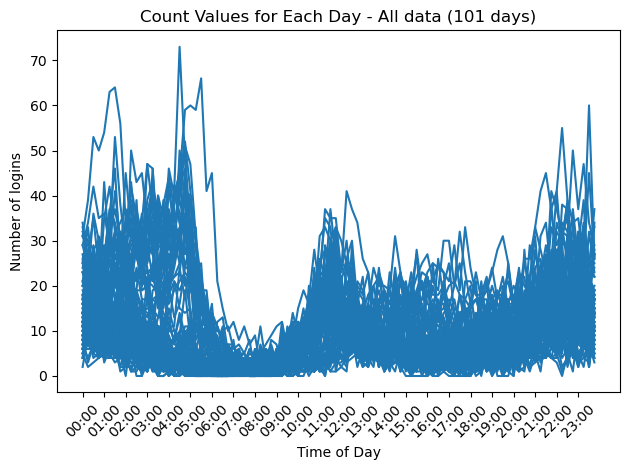

In [17]:
time_intervals = pd.date_range(start='2023-01-01 00:00', end='2023-01-01 23:59', freq='15min')
time_intervals = time_intervals.strftime('%H:%M')



for day in date_counts_dict.keys():
    plt.plot(time_intervals, date_counts_dict[day], label=day, color = 'Tab:blue')

plt.title('Count Values for Each Day - All data (101 days)')
plt.xlabel('Time of Day')
plt.ylabel('Number of logins')
plt.xticks(ticks=time_intervals[::4],rotation=45)
#plt.legend(title='Days')
#plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

Looks like most logins happen between 9pm and 5 am and there is a smaller spike between 10am and about noon. 
After the smaller spike there is a sort of plateau of activity until it picks up again after 9pm. 

There is a real between 6am and about 9:30. Interesting usage patterns. 

# <a id='toc3_'></a>[Weekly Time Series](#toc0_)

Next, weekly. Are there days of the week that have any sort of different pattern. 

In [18]:
#Make a copy of the grouped_15min data frame to work with for visualizing weekly trends. 
weekly_data = grouped_15min
weekly_data['day_of_week'] = weekly_data['login_time'].dt.day_name()
weekly_data.head()

,login_time,login_count,day_of_week
16,1970-01-02 00:00:00,10,Friday
17,1970-01-02 00:15:00,18,Friday
18,1970-01-02 00:30:00,12,Friday
19,1970-01-02 00:45:00,13,Friday
20,1970-01-02 01:00:00,9,Friday


In [19]:
weekly_dict = {'Friday':[], 
               'Saturday':[],
               'Sunday':[],
               'Monday':[],
               'Tuesday':[],
               'Wednesday':[],
               'Thursday':[]}

for day in weekly_data['day_of_week'].unique():
    weekday_df = weekly_data[weekly_data['day_of_week']==day]
    
    for date in weekday_df['login_time'].dt.date.unique():
        day_data= weekday_df[weekday_df['login_time'].dt.date == date]
        day_data = day_data.sort_values(by= 'login_time')
        day_counts = day_data['login_count'].to_list()

        weekly_dict[day].append(day_counts)


In [20]:
for key in weekly_dict.keys():
    weekday_mean_count = []
    df = pd.DataFrame(weekly_dict[key], columns = time_intervals)
    
    for column in df.columns:
        col_mean = round(df[column].mean(),0)
        weekday_mean_count.append(col_mean)

    weekly_dict[key].append(weekday_mean_count)
    

In [21]:
weekly_dict.keys()

dict_keys(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])

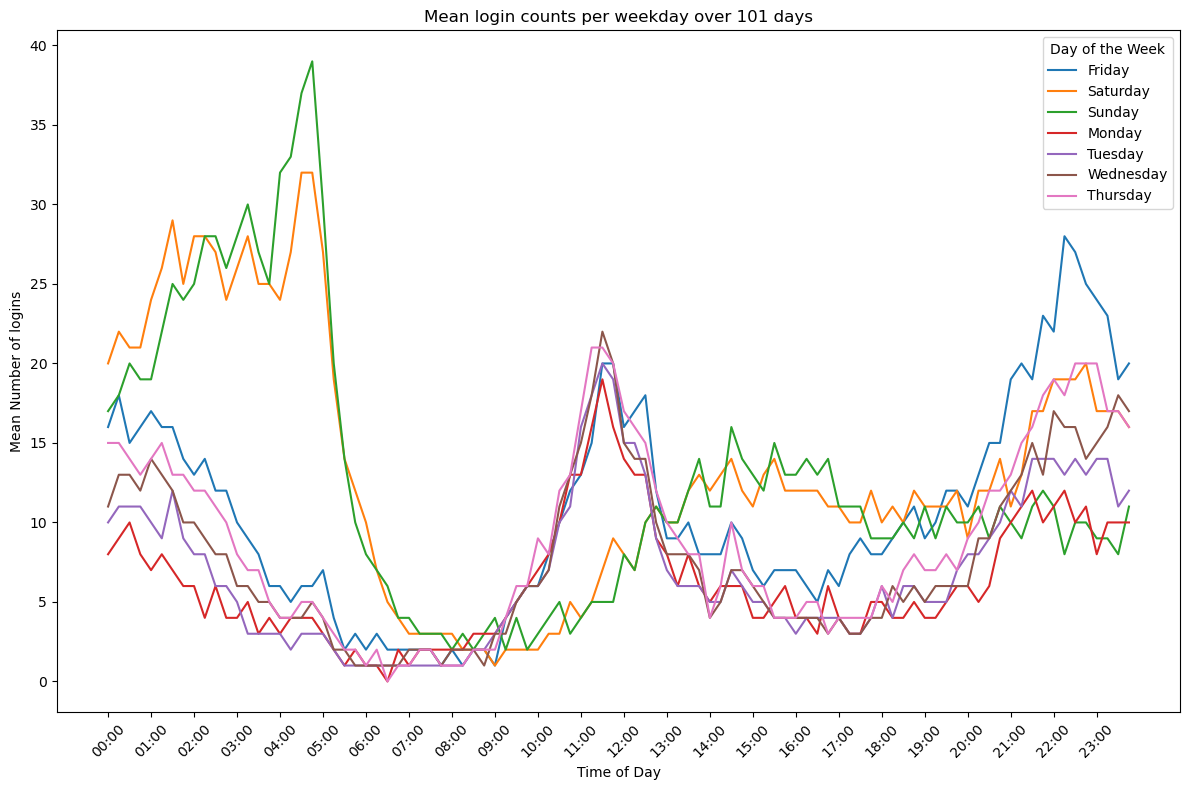

In [22]:
plt.figure(figsize=(12, 8))

for day in weekly_dict.keys():
    plt.plot(time_intervals, weekly_dict[day][-1], label=day)

plt.title('Mean login counts per weekday over 101 days')
plt.xlabel('Time of Day')
plt.ylabel('Mean Number of logins')
plt.xticks(ticks=time_intervals[::4],rotation=45)
plt.legend(title='Day of the Week', loc='upper right')
#plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

Pretty jumbled picture here. There is definitely a differece in weekday and weekend usage. 
I'll break weekdays and weekends into separate plots to see this more clearly.

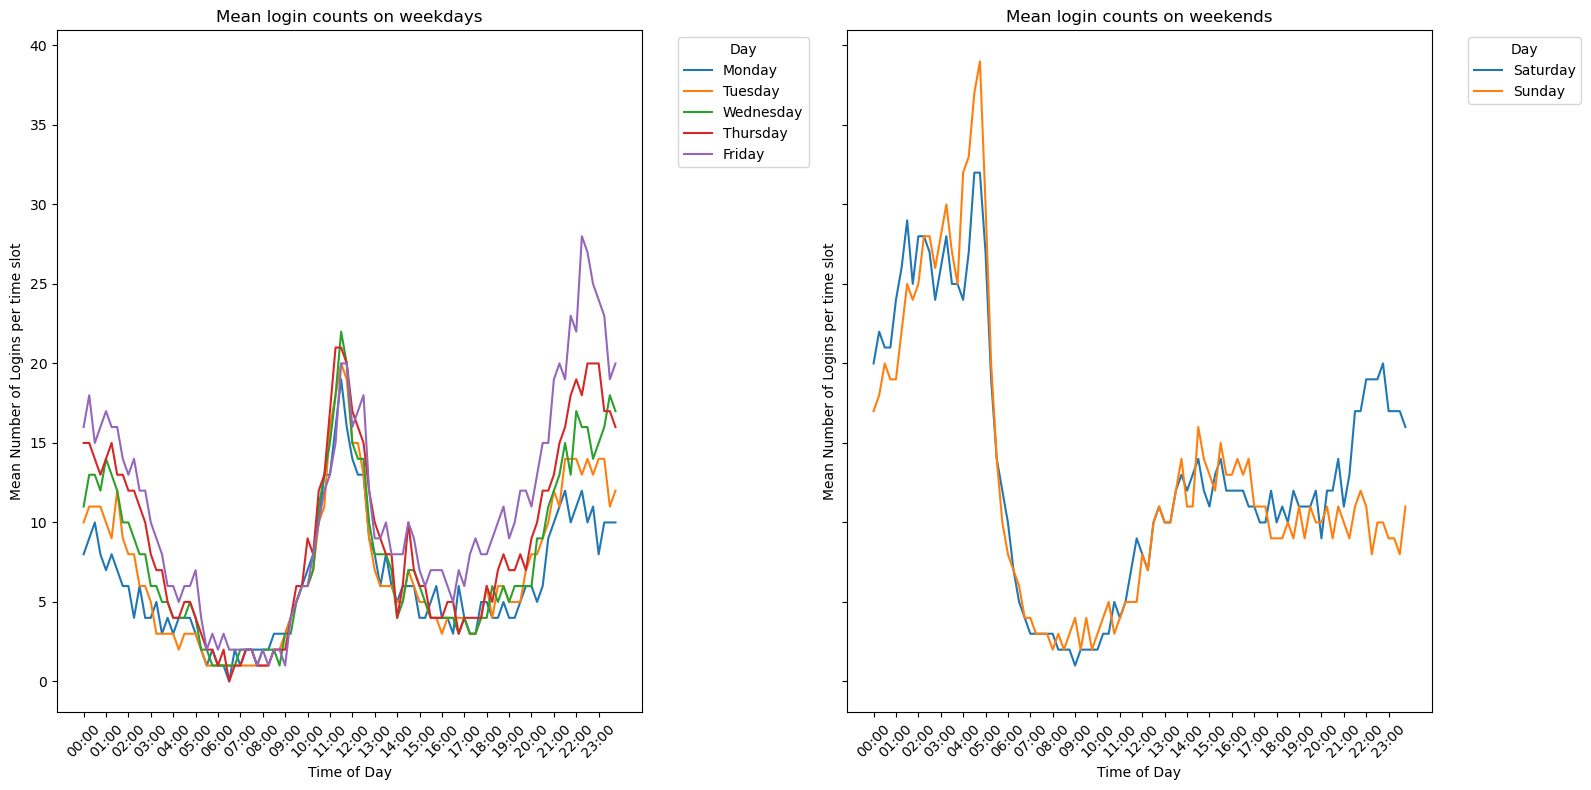

In [23]:
# Set the figure size and create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)  # 1 row, 2 columns

# First Plot
ax1.plot(time_intervals, weekly_dict['Monday'][-1], label='Monday')
ax1.plot(time_intervals, weekly_dict['Tuesday'][-1], label='Tuesday')
ax1.plot(time_intervals, weekly_dict['Wednesday'][-1], label='Wednesday')
ax1.plot(time_intervals, weekly_dict['Thursday'][-1], label='Thursday')
ax1.plot(time_intervals, weekly_dict['Friday'][-1], label='Friday')

ax1.set_title('Mean login counts on weekdays')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Mean Number of Logins per time slot')
ax1.set_xticks(time_intervals[::4])
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Day', bbox_to_anchor=(1.05, 1), loc='upper left')

# Second Plot
ax2.plot(time_intervals, weekly_dict['Saturday'][-1], label='Saturday')
ax2.plot(time_intervals, weekly_dict['Sunday'][-1], label='Sunday')

ax2.set_title('Mean login counts on weekends')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Mean Number of Logins per time slot')
ax2.set_xticks(time_intervals[::4])
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Day', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

That's clearer. The spike in the early AM hours is driven by usage on the weekend. 
All days show a low in the AM as well, although the low seems to come about an hour later on weekends. 

There is a disitinct spike around on weekdays that is not present on weekends to nearly the same extent. 

Logins after 8pm seem to increase every day from Monday to Friday, They peak on Friday and then decrease on Satudray and
Sunday again. 

## <a id='toc3_1_'></a>[Monthly Time Series](#toc0_)

Finally monthly, how does the data vary by month. There isn't a full year to look at, so this is the largest lens I can use. 
I'll visualize the weekdays and weekends separately since they have different patterns. 

In [24]:
monthly_data = grouped_15min
monthly_data['month'] = monthly_data['login_time'].dt.month_name()
monthly_data.head()

,login_time,login_count,day_of_week,month
16,1970-01-02 00:00:00,10,Friday,January
17,1970-01-02 00:15:00,18,Friday,January
18,1970-01-02 00:30:00,12,Friday,January
19,1970-01-02 00:45:00,13,Friday,January
20,1970-01-02 01:00:00,9,Friday,January


In [25]:
weekdays =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
monthly_data_weekdays = monthly_data[monthly_data['day_of_week'].isin(weekdays)]

weekends = ['Saturday', 'Sunday']
monthly_data_weekends = monthly_data[monthly_data['day_of_week'].isin(weekends)]

In [26]:
monthly_dict_weekdays = {'January':[], 
               'February':[],
               'March':[],
               'April':[]}

monthly_dict_weekends = {'January':[], 
               'February':[],
               'March':[],
               'April':[]}

dict_list = [monthly_dict_weekdays,monthly_dict_weekends]
df_list = [monthly_data_weekdays, monthly_data_weekends]

for df in df_list:

    for month in df['month'].unique():
        month_df = df[df['month']== month]
    
        for date in month_df['login_time'].dt.date.unique():
            day_data= month_df[month_df['login_time'].dt.date == date]
            day_data = day_data.sort_values(by= 'login_time')
            day_counts = day_data['login_count'].to_list()

            if df is monthly_data_weekdays:
                monthly_dict_weekdays[month].append(day_counts)

            if df is monthly_data_weekends:
                monthly_dict_weekends[month].append(day_counts)

In [27]:
for dict in dict_list:
    for key in dict.keys():
        month_mean_count = []
        df = pd.DataFrame(dict[key], columns = time_intervals)
    
        for column in df.columns:
            col_mean = round(df[column].mean(),0)
            month_mean_count.append(col_mean)

            if df is monthly_data_weekdays:
                monthly_dict_weekdays[month].append(month_mean_count)

            if df is monthly_data_weekends:
                monthly_dict_weekends[month].append(month_mean_count)

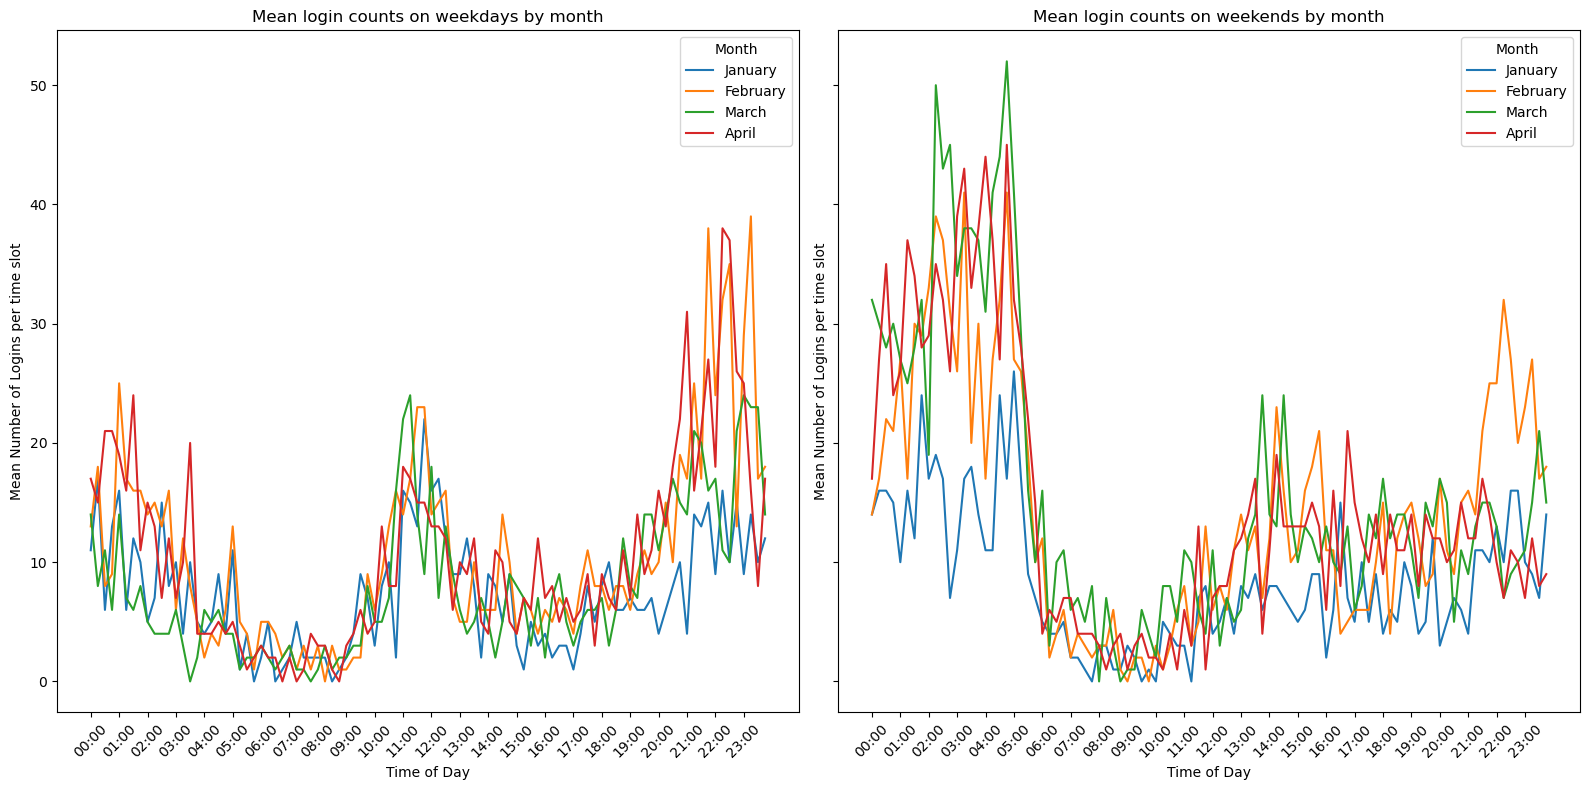

In [28]:
# Set the figure size and create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)  # 1 row, 2 columns

# First Plot
ax1.plot(time_intervals, monthly_dict_weekdays['January'][-1], label='January')
ax1.plot(time_intervals, monthly_dict_weekdays['February'][-1], label='February')
ax1.plot(time_intervals, monthly_dict_weekdays['March'][-1], label='March')
ax1.plot(time_intervals, monthly_dict_weekdays['April'][-1], label='April')

ax1.set_title('Mean login counts on weekdays by month')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Mean Number of Logins per time slot')
ax1.set_xticks(time_intervals[::4])
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Month',loc='upper right')

# Second Plot
ax2.plot(time_intervals, monthly_dict_weekends['January'][-1], label='January')
ax2.plot(time_intervals, monthly_dict_weekends['February'][-1], label='February')
ax2.plot(time_intervals, monthly_dict_weekends['March'][-1], label='March')
ax2.plot(time_intervals, monthly_dict_weekends['April'][-1], label='April')

ax2.set_title('Mean login counts on weekends by month')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Mean Number of Logins per time slot')
ax2.set_xticks(time_intervals[::4])
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Month',loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

These patters largely reflect the visualizaiton for individual weeks. 
There is some variation here between the months, with January seeming to be a lower use month than the other month
than the following months. There is also an unusual spike in February on weekends. 

This is a pretty messy plot, and probably not the best visualization depending on the actual business question at hadn. 
However, it does give a rough idea of rough monthly trends. The key takeaway is that the months we have data for all follow roughly the same pattern.
The differences beteen months seem to be differences of degree.

# <a id='toc4_'></a>[Part 2 ‐ Experiment and metrics design](#toc0_)


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. 
On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) <b>What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b>
   
   -The key here would be the net gain or loss in revenue after the toll costs are reimbursed. Having driver partners available in both cities might allow them to conduct more rides and make more money. But that increase in sales must be greater than the increase in outlay from toll reimbusements. That doesn't take into account additional wear no vehicles, fuel costs, transit times between cities etc etc. but there really isn't enough info in the question to comment on that. Bottom line is that the increase in money coming in must offset the increase in toll reimbursements. So the metic is net change in revenue produced by drivers who are being reimbursed for their tolls. 

2) <b>Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. </b>
   

<b> how you will implement the experiment?</b>

- This experiment could be in the form of an A/B test. Generally speaking, you would choose a subset of the drivers at random and give them the toll reimbursements. The other group of drivers would not get reimbursed. You could also run the test by taking the same set of drivers and comparing their sales before and after the toll reimbursements, but the general idea is the same. After some period of time, you would examine the net change in revenue (if any) between the two groups. If there was a statistically significant increase in revenue for the reimbursed group, you would consider implementing the toll scheme with all drivers. To conduct this experiment successfully, you would need an understanding of the current baseline driver revenue. You would also need to settle on the desired sensitivity of the experiment, and you would need to calculate the sample size based on the desired statistical power. Finally, you would need to determine the appropriate confidence level. 0.95 would be standard. There are, of course, lots of other business factors that would come into play in the real world.



<b>What statistical test(s) you will conduct to verify the significance of the observation?</b>

- At the end of the experiment, you would have two distributions. One would be the sales from the non-toll group, and one would be the sales from the toll group with the toll reimbursements subtracted for each driver. You would want to know if these two distributions were actually different or if any differences were likely the result of random chance. You could use a t-test to look at the means of the two distributions and determine if they are statistically different and if that difference is positive enough and large enough to merit making operational changes.


<b> How you would interpret the results and provide recommendations to the city operations team along with any caveats?</b>

- A lot would depend on the details of the results and the operations. If the experiment showed that reimbursing the tolls made no difference or resulted in fewer sales, the recommendation would be to not institute the toll scheme. If the experiment showed that reimbursing the tolls led to a modest increase in revenue, then the recommendation might be to institute the scheme with a larger group of drivers for a longer period of time as a larger experiemnt. If the experiment showed that the increase in net sales was substantial, the recommendation might be to implement the scheme with the entire driver fleet right away.

In all scenarios, the caveats would be that the results of the experiemnt may not translate fully to the real world. Even at a 0.95 confidence interval the results could still be chance. There might also be seasonal fluctuations or other factors that the experiment didn't capture. 

# <a id='toc5_'></a>[Part 3 ‐ Predictive modeling](#toc0_)

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

## <a id='toc5_1_'></a>[EDA](#toc0_)

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [29]:
ult_data_challenge_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [30]:
ult_data_challenge_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [31]:
ult_data_challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


This looks pretty clean but there are a couple of obvious issues:

1. There are some missing values here which need to be dealt with. They are in the average ratings sections, which isn't too surprising since not all 
drivers might be rated. 

2. The dates seems to be listed here as strings. They will need to be converted to datetime objects to 

3. There is no label for wheter a user has been retained or not. We're trying to build a model for a user being retained in their 6th month, 
meaning they were active if they took a trip in the "preceeding 30 days". I'll have to parse the data and add positive and negative class labels before I can proceed with 
modeling. 

### <a id='toc5_1_1_'></a>[Data Wrangling - Missing Values](#toc0_)

There are no driver or user ID's in the data, so there really isn't a way tp impute missing driver or rider ratings based on other ratings we have for that particualr person.
If those values can't be imputed, then the best option is just to drop the rows with missing values. 

The phone column also has missing values, but they are None objects instead of Nan. This makes me think that None is reffering to a legitimate 3rd option, maybe booking a ride 
via an internet browser or something similar. Hard to tell within the context of a take home exersize. I'm going to assume that None for phone is a legitimate value, not
just an alternative was of saying Nan. I'll convert the phone None values to a string to prevent the None values from causing issues. 

In [32]:
#Fill in None values in phone column with "Other"
# 
ult_data_challenge_df.fillna({'phone': 'None'}, inplace = True)

In [33]:
ult_data_challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [34]:
#Drop any rows with remaining Nan values
ult_data_challenge_df.dropna(inplace = True)

In [35]:
ult_data_challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41744 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41744 non-null  object 
 1   trips_in_first_30_days  41744 non-null  int64  
 2   signup_date             41744 non-null  object 
 3   avg_rating_of_driver    41744 non-null  float64
 4   avg_surge               41744 non-null  float64
 5   last_trip_date          41744 non-null  object 
 6   phone                   41744 non-null  object 
 7   surge_pct               41744 non-null  float64
 8   ultimate_black_user     41744 non-null  bool   
 9   weekday_pct             41744 non-null  float64
 10  avg_dist                41744 non-null  float64
 11  avg_rating_by_driver    41744 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.9+ MB


No more null values and all the data types look correct except for the dates. I'll deal with those in the next section. 

### <a id='toc5_1_2_'></a>[Data Wrangling - Assign Positive and Negative Classes](#toc0_)

<b>Positive class</b> 
<br> Users who are active in their 6th month on the platform. 

<b>Negative class</b>
<br>Users who are not active in their 6th months on the platform. 

To define these classes I'll need to determine if those users were active in that 6th month. 
Being active in the 6th month means that they took a trip in the preceeding 30 days. 
So a user who took a trip within 30 days of the first day of the 6th month is still technically an active user. 
I'll have to account for that time offset. 

In [36]:
#Convert data columns to datetimes
ult_data_challenge_df[['signup_date', 'last_trip_date']] = ult_data_challenge_df[['signup_date', 'last_trip_date']].apply(lambda x: pd.to_datetime(x, errors='coerce'))

In [37]:
#check to be sure that all dates were converted correctly. - If not there will be NaT values that show as null when looking at .info()
ult_data_challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41744 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41744 non-null  object        
 1   trips_in_first_30_days  41744 non-null  int64         
 2   signup_date             41744 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               41744 non-null  float64       
 5   last_trip_date          41744 non-null  datetime64[ns]
 6   phone                   41744 non-null  object        
 7   surge_pct               41744 non-null  float64       
 8   ultimate_black_user     41744 non-null  bool          
 9   weekday_pct             41744 non-null  float64       
 10  avg_dist                41744 non-null  float64       
 11  avg_rating_by_driver    41744 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1)

In [38]:
#figrue out what date is 6 months from sign up and add 30 days - That added 30 days is the 6th months
ult_data_challenge_df['6_months_from_signup'] = ult_data_challenge_df['signup_date'] + pd.DateOffset(months = 6)

In [39]:
# subtract 1 month and 30 days from the 6th month - any user who takes a ride within 30 days of the first day of the 6th month is an active 6 month user.
ult_data_challenge_df['last_active_user_day'] = ult_data_challenge_df['6_months_from_signup'] - pd.DateOffset(months=1) - pd.Timedelta(days=30)

In [40]:
ult_data_challenge_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6_months_from_signup,last_active_user_day
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25,2014-05-26
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29,2014-05-30
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06,2014-05-07
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10,2014-05-11
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27,2014-05-28


In [41]:
ult_data_challenge_df['active_6mo_user'] =ult_data_challenge_df['last_trip_date']>=ult_data_challenge_df['last_active_user_day']

In [42]:
ult_data_challenge_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6_months_from_signup,last_active_user_day,active_6mo_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25,2014-05-26,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29,2014-05-30,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06,2014-05-07,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10,2014-05-11,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27,2014-05-28,False


In [43]:
#Check for imbalanced classes
ult_data_challenge_df['active_6mo_user'].value_counts()

active_6mo_user
False    21437
True     20307
Name: count, dtype: int64

Looks like the classes are pretty equal. No serious imbalance we need to address. 

### <a id='toc5_1_3_'></a>[Final data wrangling](#toc0_)

Below I'll drop a number of columns that are no longer needed. This will include the last_trip_data column. 
I'm dropping this because it seems to result in data leakage. If the model knows the last trip date, it knows if the user is active or not. 
Preliminary modeling showed that included the last trip date caused the model to be extremely accurate, but it was really just accurate in predicting if 
a user was active by determining that they had take a trip within the timeframe that would make them an active user. Not very helpful.

In [44]:
#drop the last_active_user_day and 6_months_from_signup columns as they are no longer needed
ult_data_challenge_df.drop(columns=['last_active_user_day','6_months_from_signup'])

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6mo_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,True
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,True
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,True
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,False


In [45]:
#extract date data and remove datetime objects

#sign_up_date
ult_data_challenge_df['signup_year'] = ult_data_challenge_df['signup_date'].dt.year
ult_data_challenge_df['signup_month'] = ult_data_challenge_df['signup_date'].dt.month
ult_data_challenge_df['signup_day'] = ult_data_challenge_df['signup_date'].dt.day

#last_trip_date
#ult_data_challenge_df['last_trip_year'] = ult_data_challenge_df['last_trip_date'].dt.year
#ult_data_challenge_df['last_trip_month'] = ult_data_challenge_df['last_trip_date'].dt.month
#ult_data_challenge_df['last_trip_day'] = ult_data_challenge_df['last_trip_date'].dt.day


ult_data_challenge_df.drop(columns=['last_active_user_day','6_months_from_signup','signup_date','last_trip_date'], inplace = True)

In [46]:
#convert boolean columns to ints
boolean_columns = ['ultimate_black_user', 'active_6mo_user']
ult_data_challenge_df[boolean_columns] = ult_data_challenge_df[boolean_columns].astype(int)

In [ ]:
ult_data_challenge_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6mo_user,signup_year,signup_month,signup_day
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,2014,1,25
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,2014,1,29
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0,2014,1,6
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,2014,1,10
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0,2014,1,27


## <a id='toc5_2_'></a>[Modeling](#toc0_)

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

To do this I'll first try two out of the box models, a random forest classifier and an XGBoost model. I'll train them and then show them the test set to see how they perform
in a general sense without tuning. Based on those results, I'll select a model to develop, tune it, and then interpret the results.

### <a id='toc5_2_1_'></a>[Encode Categorical Variables](#toc0_)

In [48]:
ult_data_challenge_df = pd.get_dummies(ult_data_challenge_df, columns=['city', 'phone'], drop_first=True)

In [ ]:
ult_data_challenge_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6mo_user,signup_year,signup_month,signup_day,city_King's Landing,city_Winterfell,phone_None,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,2014,1,25,True,False,False,True
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,2014,1,29,False,False,False,False
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,2014,1,6,False,False,False,True
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,2014,1,10,True,False,False,True
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,2014,1,27,False,True,False,False


### <a id='toc5_2_2_'></a>[Train Test Split](#toc0_)

In [50]:
X = ult_data_challenge_df.drop('active_6mo_user', axis=1)  # Replace 'target_variable' with your actual target variable name
y = ult_data_challenge_df['active_6mo_user']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <a id='toc5_2_3_'></a>[Random Forest Baseline](#toc0_)

In [52]:
# Create the Random Forest model
rf_baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators

#generate cross_validation scores
rf_baseline_accuracy_scores = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='accuracy')
rf_baseline_f1_scores = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='f1')
rf_baseline_roc_auc_scores = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='roc_auc')
rf_baseline_precision = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='precision')
rf_baseline_recall = cross_val_score(rf_baseline_model, X_train, y_train, cv=5, scoring='recall')

# Print the scores
print("Accuracy Scores:", rf_baseline_accuracy_scores)
print("F1 Macro Scores:", rf_baseline_accuracy_scores)
print("ROC AUC Scores:", rf_baseline_accuracy_scores)
print("Precision:", rf_baseline_accuracy_scores)
print("Recall:", rf_baseline_accuracy_scores)

Accuracy Scores: [0.74831562 0.74771672 0.74831562 0.74577032 0.7534062 ]
F1 Macro Scores: [0.74831562 0.74771672 0.74831562 0.74577032 0.7534062 ]
ROC AUC Scores: [0.74831562 0.74771672 0.74831562 0.74577032 0.7534062 ]
Precision: [0.74831562 0.74771672 0.74831562 0.74577032 0.7534062 ]
Recall: [0.74831562 0.74771672 0.74831562 0.74577032 0.7534062 ]


Decent scores here for a first pass. How will they hold up if the baseline model predicts on the test set? 

In [53]:
rf_baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_baseline_model.predict(X_test)
y_scores_rf = rf_baseline_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

rf_baseline_test_set_accuracy = accuracy_score(y_test, y_pred_rf)
rf_baseline_test_set_f1 = f1_score(y_test, y_pred_rf, average='binary')      
rf_baseline_test_set_roc_auc = roc_auc_score(y_test, y_scores_rf)         
rf_baseline_test_set_precision = precision_score(y_test, y_pred_rf, average='binary')
rf_baseline_test_set_recall = recall_score(y_test, y_pred_rf, average='binary')

print("RF baseline test set Accuracy:", rf_baseline_test_set_accuracy)
print("RF baseline test set F1 Score:", rf_baseline_test_set_f1)
print("RF baseline test set ROC AUC:", rf_baseline_test_set_roc_auc)
print("RF baseline test set Precision:", rf_baseline_test_set_precision)
print("RF baseline test set Recall:", rf_baseline_test_set_recall)

RF baseline test set Accuracy: 0.7521858905258115
RF baseline test set F1 Score: 0.7444101297096972
RF baseline test set ROC AUC: 0.8349392041722291
RF baseline test set Precision: 0.751746506986028
RF baseline test set Recall: 0.7372155615365794


Still decent results - this is a model that might be worth developing further. 

### <a id='toc5_2_4_'></a>[XGBoost baseline](#toc0_)

In [54]:
xgb_baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [55]:
xgb_baseline_accuracy_scores = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='accuracy')
xgb_baseline_f1_scores = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='f1')
xgb_baseline_roc_auc_scores = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='roc_auc')
xgb_baseline_precision = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='precision')
xgb_baseline_recall = cross_val_score(xgb_baseline_model, X_train, y_train, cv=5, scoring='recall')

# Print the scores
print("Accuracy Scores:", xgb_baseline_accuracy_scores)
print("F1 Macro Scores:", xgb_baseline_f1_scores)
print("ROC AUC Scores:", xgb_baseline_roc_auc_scores)
print("Precision:", xgb_baseline_precision)
print("Recall:", xgb_baseline_recall)

Accuracy Scores: [0.7644857  0.76762988 0.76688127 0.7592454  0.78185357]
F1 Macro Scores: [0.75340963 0.75450807 0.75886635 0.74976657 0.77252147]
ROC AUC Scores: [0.84785671 0.84762168 0.84890098 0.84119288 0.86428843]
Precision: [0.76650718 0.7748538  0.76252723 0.75707102 0.78266371]
Recall: [0.74075216 0.73520345 0.75524044 0.74260173 0.76263872]


Very similar to random forest, maybe a little better. How does the baseline do on the test set? 

In [ ]:
xgb_baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb= xgb_baseline_model.predict(X_test)
y_scores_xgb = xgb_baseline_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

xgb_baseline_test_set_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_baseline_test_set_f1 = f1_score(y_test, y_pred_xgb, average='binary')      
xgb_baseline_test_set_roc_auc = roc_auc_score(y_test, y_scores_xgb)         
xgb_baseline_test_set_precision = precision_score(y_test, y_pred_xgb, average='binary')
xgb_baseline_test_set_recall = recall_score(y_test, y_pred_xgb, average='binary')

print("XGB baseline test set Accuracy:", xgb_baseline_test_set_accuracy)
print("XGB baseline test set F1 Score:", xgb_baseline_test_set_f1)
print("XGB baseline test set ROC AUC:", xgb_baseline_test_set_roc_auc)
print("XGB baseline test set Precision:", xgb_baseline_test_set_precision)
print("XGB baseline test set Recall:", xgb_baseline_test_set_recall)

XGB baseline test set Accuracy: 0.767756617558989
XGB baseline test set F1 Score: 0.757473420888055
XGB baseline test set ROC AUC: 0.8537134660413344
XGB baseline test set Precision: 0.77482088024565
XGB baseline test set Recall: 0.7408857352581355


### <a id='toc5_2_5_'></a>[ADA Boost](#toc0_)

In [57]:
# Base model for AdaBoost (usually a Decision Tree with a low max depth)
base_model = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost with the base model
ada_boost_baseline = AdaBoostClassifier(
    base_estimator=base_model, 
    n_estimators=100,           # Number of boosting rounds
    learning_rate=1.0,         # Controls the contribution of each classifier
    random_state=42            # Ensures reproducibility
)

In [58]:
adaboost_baseline_accuracy_scores = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='accuracy')
adaboost_baseline_f1_scores = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='f1')
adaboost_baseline_roc_auc_scores = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='roc_auc')
adaboost_baseline_precision = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='precision')
adaboost_baseline_recall = cross_val_score(ada_boost_baseline, X_train, y_train, cv=5, scoring='recall')

# Print the scores
print("Accuracy Scores:", adaboost_baseline_accuracy_scores)
print("F1 Macro Scores:", adaboost_baseline_f1_scores)
print("ROC AUC Scores:", adaboost_baseline_roc_auc_scores)
print("Precision:", adaboost_baseline_precision)
print("Recall:", adaboost_baseline_recall)

Accuracy Scores: [0.76134152 0.76223986 0.76194041 0.75999401 0.77152268]
F1 Macro Scores: [0.74842172 0.74841572 0.75125156 0.74791634 0.75998742]
ROC AUC Scores: [0.83860303 0.83794209 0.84092123 0.83750841 0.85214984]
Precision: [0.76681759 0.76988266 0.76270648 0.76340289 0.775851  ]
Recall: [0.73088779 0.72811344 0.74013564 0.73304562 0.74475956]


In [59]:
# Train the AdaBoost model
ada_boost_baseline.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_boost_baseline.predict(X_test)
y_scores_ada = ada_boost_baseline.predict_proba(X_test)[:, 1]  # Probability of the positive class

In [60]:
adaboost_baseline_test_set_accuracy = accuracy_score(y_test,y_pred_ada)
adaboost_baseline_test_set_f1 = f1_score(y_test, y_pred_ada, average='binary')      
adaboost_baseline_test_set_roc_auc = roc_auc_score(y_test,y_scores_ada)         
adaboost_baseline_test_set_precision = precision_score(y_test, y_pred_ada, average='binary')
adaboost_baseline_test_set_recall = recall_score(y_test, y_pred_ada, average='binary')

print("ADAboost baseline test set Accuracy:", adaboost_baseline_test_set_accuracy)
print("ADAboost baseline test set F1 Score:", adaboost_baseline_test_set_f1)
print("ADAboost baseline test set ROC AUC:", adaboost_baseline_test_set_roc_auc)
print("ADAboost baseline test set Precision:", adaboost_baseline_test_set_precision)
print("ADAboost baseline test set Recall:", adaboost_baseline_test_set_recall)

ADAboost baseline test set Accuracy: 0.7608096778057253
ADAboost baseline test set F1 Score: 0.7499686991360961
ADAboost baseline test set ROC AUC: 0.8409542015365702
ADAboost baseline test set Precision: 0.767948717948718
ADAboost baseline test set Recall: 0.732811353070712


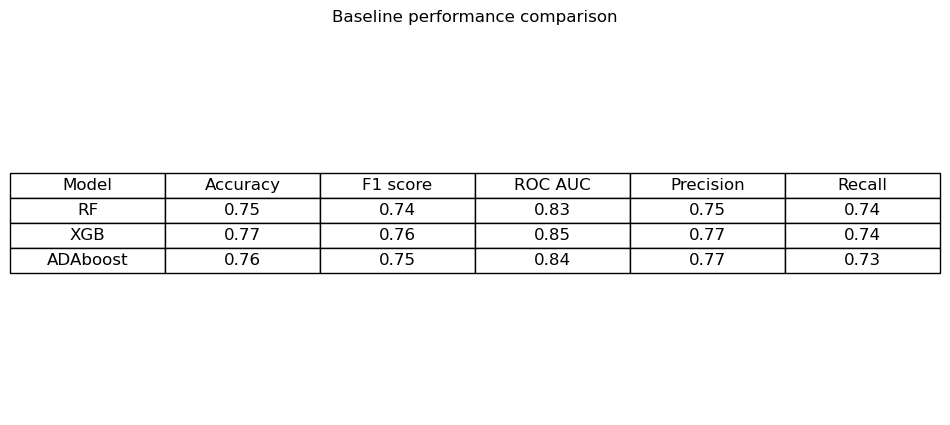

In [61]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Data for the table
data = [
    ['Model', 'Accuracy', 'F1 score','ROC AUC', 'Precision','Recall'],
    ['RF', round(rf_baseline_test_set_accuracy,2), round(rf_baseline_test_set_f1,2),round(rf_baseline_test_set_roc_auc,2),round(rf_baseline_test_set_precision,2),round(rf_baseline_test_set_recall,2)],
    ['XGB', round(xgb_baseline_test_set_accuracy,2), round(xgb_baseline_test_set_f1,2), round(xgb_baseline_test_set_roc_auc,2),round(xgb_baseline_test_set_precision,2),round(xgb_baseline_test_set_recall,2)],
    ['ADAboost', round(adaboost_baseline_test_set_accuracy,2), round(adaboost_baseline_test_set_f1,2), round(adaboost_baseline_test_set_roc_auc,2),round(adaboost_baseline_test_set_precision,2),round(adaboost_baseline_test_set_recall,2)]
]

# Create a table and add it to the axes
table = ax.table(cellText=data, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.5) 

# Hide axes
ax.axis('off')

# Show the plot

plt.title('Baseline performance comparison')
plt.show()

Of the three models tried, it looks like XGB is doing a little better. I'll use that for the final model.

## <a id='toc5_3_'></a>[Final model development](#toc0_)

For the final model, I'll use BayesSearchCV to find the best parameters for an XGBoost classifier model. 
I'm using F0.5 as the scoring parameter so that I can give more weight to precision over recall.  

 If user retention is the goal, then giving more weight to precision, and therby lowering the rate of false positives seems like a good idea. 
 This is because a user classified as a false positive will look like they will be retained and therefore won't be flagged as a target for additional actions
 to improve their retention. 

 A user classified as a false negative might be targeted with additional actions, but those would be wasted, because the user will be retained regardless. 

In [62]:
#Intitialize final model
xgb_final_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [ ]:
# Use Baysean search to find the best parameters

from skopt import BayesSearchCV

search_space = {
    'n_estimators':(1000,2500), 
    'eta': (0.1,0.4),
    'gamma':(0,8),
    'max_depth':(1,12),
    'min_child_weight':(0,10),
    'lambda':(0,10),
    'alpha':(0,10)
}

f03_scorer = make_scorer(fbeta_score, beta=0.3)


bayes_search = BayesSearchCV(xgb_final_model, 
                             search_space, 
                             n_iter=200, 
                             cv=5, 
                             scoring= f03_scorer, 
                             verbose = 0, 
                             n_jobs=-1,
                             random_state=42)

bayes_search.fit(X_train, y_train)

best_params = bayes_search.best_params_

print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", bayes_search.best_score_)


Best Parameters: OrderedDict([('alpha', 8), ('eta', 0.1), ('gamma', 0), ('lambda', 0), ('max_depth', 4), ('min_child_weight', 10), ('n_estimators', 2317)])
Best Score: 0.7755422022057711


### <a id='toc5_3_1_'></a>[Test set performance](#toc0_)

In [64]:
#Instantiate final model with best params
n_estimators_value = best_params['n_estimators']
min_child_weight_value = best_params['min_child_weight']
max_depth_value = best_params['max_depth']
lambda_value = best_params['lambda']
gamma_value = best_params['gamma']
eta_value = best_params['eta']
alpha_value = best_params['alpha']

xgb_final_model_best_params = XGBClassifier(use_label_encoder=False, 
                                eval_metric='logloss',
                                n_estimators= n_estimators_value,
                                min_child_weight = min_child_weight_value,
                                max_depth = max_depth_value,
                                reg_lambda = lambda_value,
                                gamma = gamma_value,
                                eta = eta_value,
                                alpha = alpha_value
                                )

In [65]:
#Train model with best params
xgb_final_model_best_params.fit(X_train, y_train)

#Predict on test set
y_pred_final= xgb_final_model_best_params.predict(X_test)
y_scores_xgb_final = xgb_final_model_best_params.predict_proba(X_test)[:, 1]  # Probability of the positive class

In [85]:
# calculate optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_xgb_final)

# Calculate F0.3 score for each threshold
beta = 0.5
fbeta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-10)  # Add a small constant to avoid division by zero

# Find the optimal threshold based on the maximum F0.3 score
optimal_idx = np.argmax(fbeta_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_fbeta = fbeta_scores[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Max F0.5 Score: {optimal_fbeta:.2f}')

Optimal Threshold: 0.66
Max F0.5 Score: 0.79


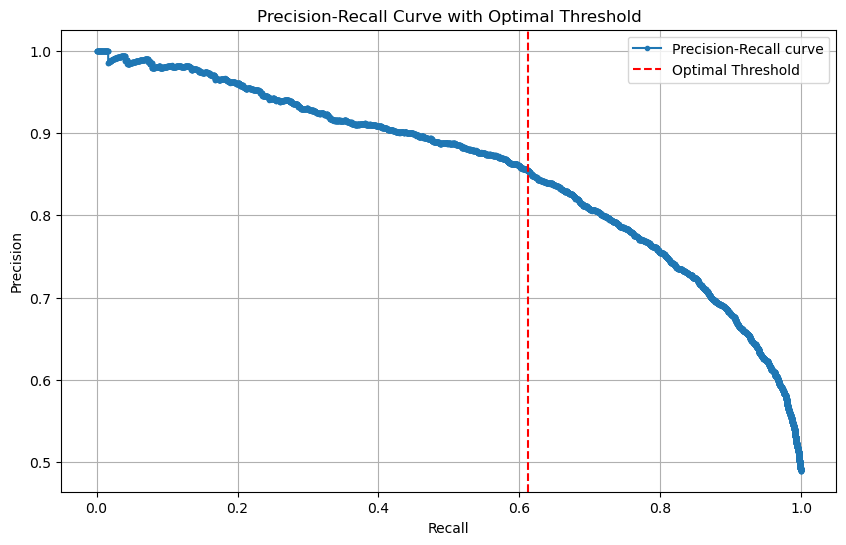

In [86]:
# Optional: Plot Precision-Recall curve with the optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.axvline(recall[optimal_idx], color='red', linestyle = '--',label='Optimal Threshold')
#plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label='Optimal Threshold')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()

In [87]:
# Apply optimal threshold to predicitons
y_pred_optimal = (y_scores_xgb_final >= optimal_threshold).astype(int)

In [88]:
final_xgb_model_test_set_accuracy = accuracy_score(y_test, y_pred_optimal)
final_xgb_model_test_set_f1 = f1_score(y_test, y_pred_optimal, average='binary')      
final_xgb_model_test_set_roc_auc = roc_auc_score(y_test, y_pred_optimal)         
final_xgb_model_test_set_precision = precision_score(y_test, y_pred_optimal, average='binary')
final_xgb_model_test_set_recall = recall_score(y_test,y_pred_optimal, average='binary')

print("Final model test set Accuracy:", final_xgb_model_test_set_accuracy)
print("Final model test set F1 Score:", final_xgb_model_test_set_f1)
print("Final model test set ROC AUC:", final_xgb_model_test_set_roc_auc)
print("Final model test set Precision:", final_xgb_model_test_set_precision)
print("Final model test set Recall:", final_xgb_model_test_set_recall)

Final model test set Accuracy: 0.7592526051024074
Final model test set F1 Score: 0.7134302822925578
Final model test set ROC AUC: 0.7562332673547892
Final model test set Precision: 0.8548001366586949
Final model test set Recall: 0.6121849767555664


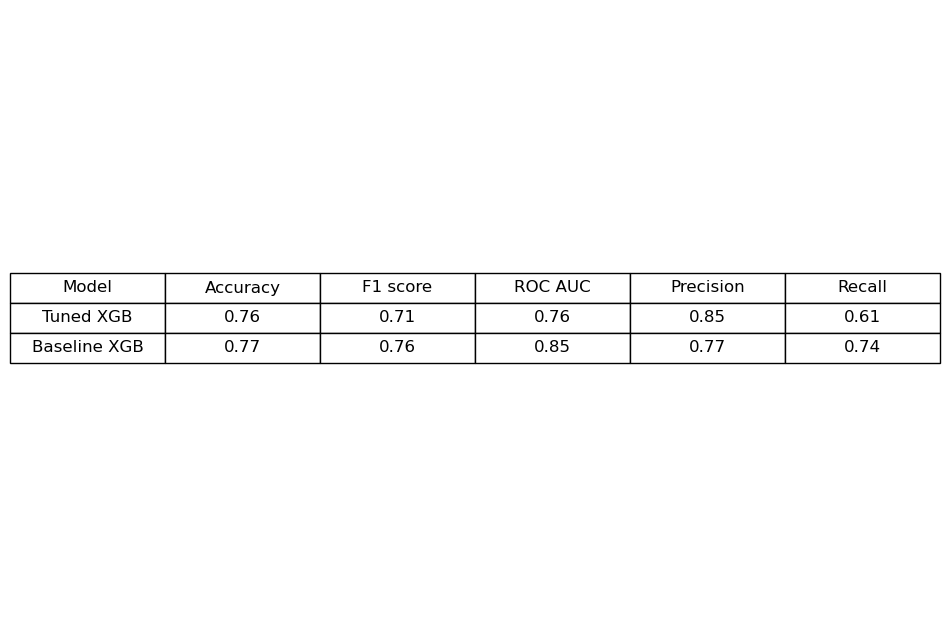

In [89]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Data for the table
data = [
    ['Model', 'Accuracy', 'F1 score','ROC AUC', 'Precision','Recall'],
    ['Tuned XGB', round(final_xgb_model_test_set_accuracy,2), round(final_xgb_model_test_set_f1,2),round(final_xgb_model_test_set_roc_auc,2),round(final_xgb_model_test_set_precision,2),round(final_xgb_model_test_set_recall,2)],
    ['Baseline XGB', round(xgb_baseline_test_set_accuracy,2), round(xgb_baseline_test_set_f1,2), round(xgb_baseline_test_set_roc_auc,2),round(xgb_baseline_test_set_precision,2),round(xgb_baseline_test_set_recall,2)]
]


# Create a table and add it to the axes
table = ax.table(cellText=data, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.8) 

# Hide axes
ax.axis('off')

# Show the plot
plt.show()

Even with F0.5 score used for optimization and for choosing the threshold the tuned model is higher in precision than the baseline model. 
This makes for fewer false positives, but at the expense of the other metrics. 

Even so, the model is still performing well enough for us to gain some insights in terms of the features that are driving 
the classifictions. More on that below. 

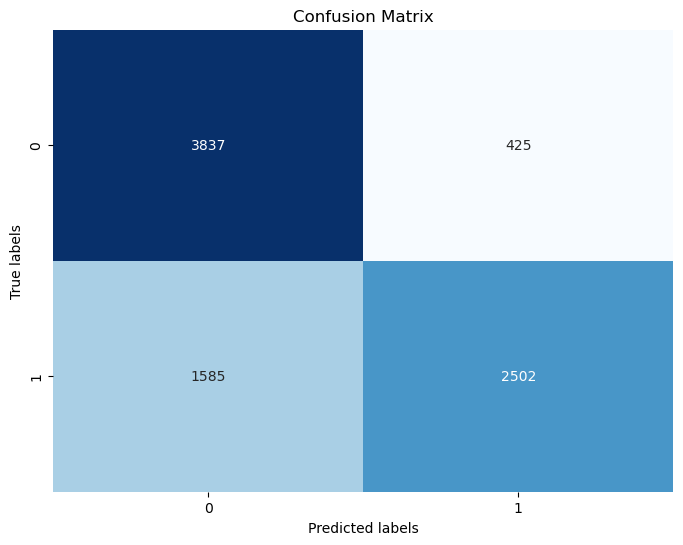

In [90]:
# Assuming y_test is your true labels and y_pred is the predicted labels
conf_mat = confusion_matrix(y_test, y_pred_optimal)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The model is producing a lot of false negatives. Perhaps too many given the business case. However, a false negative in this case is theoretically better than a false positive. 
It really would depend on what business processes are impacted by a false positive vs. a false negative. The model could be adjusted further if needed. 

### <a id='toc5_3_2_'></a>[Model interpretation](#toc0_)

In [91]:
#Train model with best params on all the data
n_estimators_value = best_params['n_estimators']
min_child_weight_value = best_params['min_child_weight']
max_depth_value = best_params['max_depth']
lambda_value = best_params['lambda']
gamma_value = best_params['gamma']
eta_value = best_params['eta']
alpha_value = best_params['alpha']

xgb_final_model_best_params_all_data = XGBClassifier(
                                use_label_encoder=False, 
                                eval_metric='logloss',
                                n_estimators= n_estimators_value,
                                min_child_weight = min_child_weight_value,
                                max_depth = max_depth_value,
                                reg_lambda = lambda_value,
                                gamma = gamma_value,
                                eta = eta_value,
                                alpha = alpha_value
                                )

xgb_final_model_best_params_all_data.fit(X,y)

XGBClassifier(alpha=8, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2317,
              n_jobs=None, ...)

In [92]:
# Retrieve feature importances
importances = xgb_final_model_best_params_all_data.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

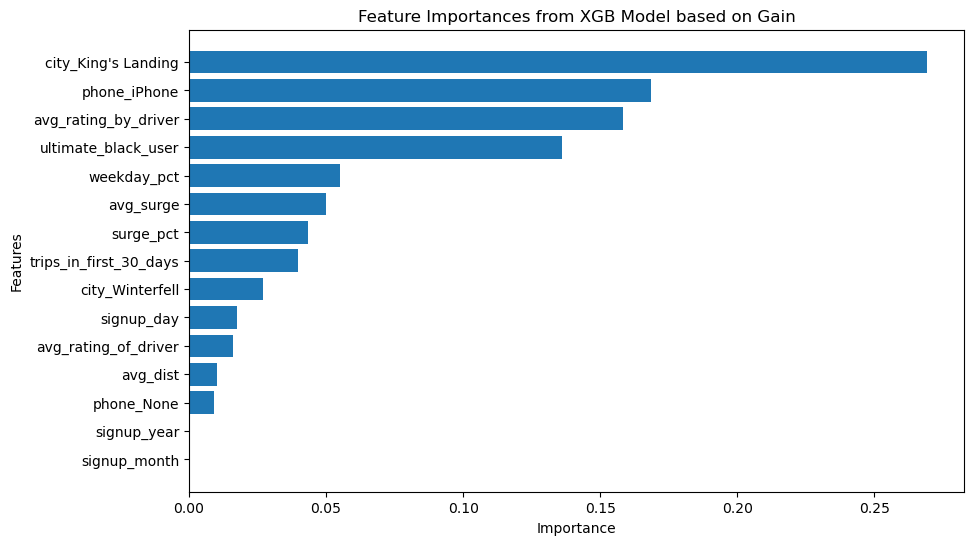

In [93]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from XGB Model based on Gain')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

The feature importances from the model here can be calulated in several different ways, but the major features in terms of the top 5
are consistent enought to serve as the basis for recommendations. 

The SHAP plot below goes into further detail.

Note that because of the different ways the features are calcualted, the SHAP plot and model importances don't match exactly. 

[15:25:01] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_d6q0e1lomi/croot/xgboost-split_1713972719224/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


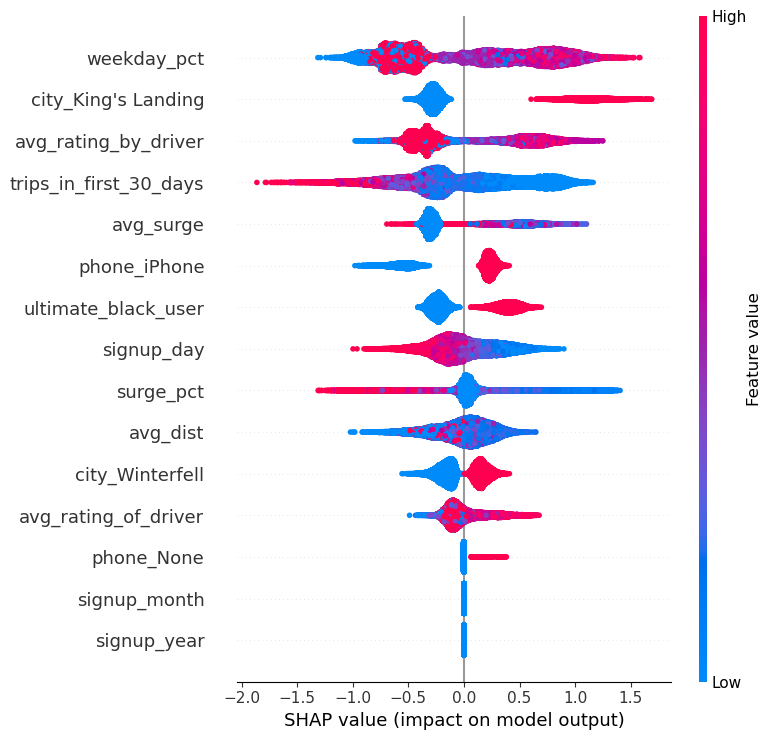

In [75]:
# Create SHAP values
explainer = shap.TreeExplainer(xgb_final_model_best_params_all_data)  # For tree-based models
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot (feature importances)
shap.summary_plot(shap_values, X)  # Bar plot for importance ranking



The features with the higherst impact and importance are broken down below in more details. 

Based on this plot, there are a few obvious things that stand out. 

1. Being in Kings Landing seems to have a positive impact on retention
2. Having an Iphone has a positive impace on retention while not having an Iphone (having an Android) has a negative effect. 
3. Using Ultimate Black in the first 30 days has a positve impact. 

The other top features such as weekday_pct and avg_rating_by_driver are more complicated and are dealt with below. 
The plots are very simple and should be thought of as a starting point. Additional feature interactions can be explored
if appropriate to the specific business question at hand. 

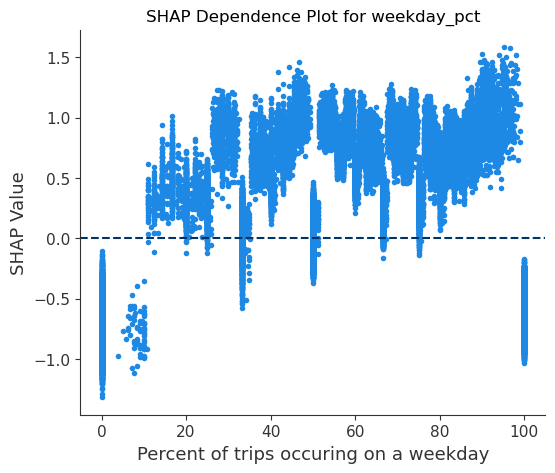

In [76]:
shap.dependence_plot('weekday_pct', shap_values, X, show = False, interaction_index=None)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line

# Add a title to the plot
ax.set_title('SHAP Dependence Plot for weekday_pct')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Percent of trips occuring on a weekday')
ax.set_ylabel('SHAP Value')

# Show the plot
plt.show()

Using the service only on weekends or only on weekdays seems to have a negative impact on retention. 

Almost any other usage pattern has a positive impact, 
with the most positive impaces fomring at roughly 50% weekday usage and roughly 90-98%
weekday usage. 

Riders who use the service on both weekdays and weekends are most likely to be retained.

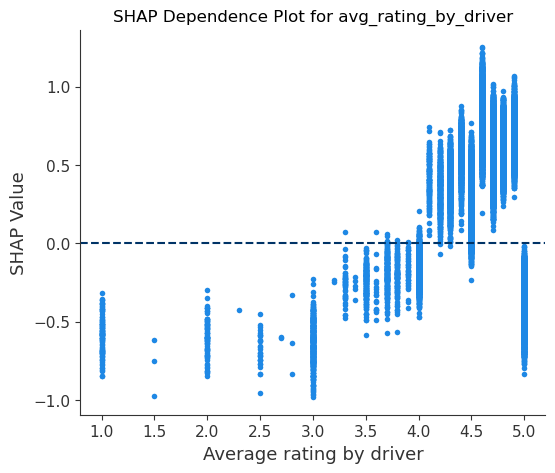

In [77]:
shap.dependence_plot('avg_rating_by_driver', shap_values, X, show = False, interaction_index=None)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line

# Add a title to the plot
ax.set_title('SHAP Dependence Plot for avg_rating_by_driver')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Average rating by driver')
ax.set_ylabel('SHAP Value')

# Show the plot
plt.show()

A more complicated picture here, since it's not intuitivly clear why drivers rating riders between approximatley 4.0 and 4.9
would have a positive impact on retention. More research could be done to understand what riders with these average ratings have in common. 
There may be an additional factor causing the high ratings that's important but not captured in the data here. 

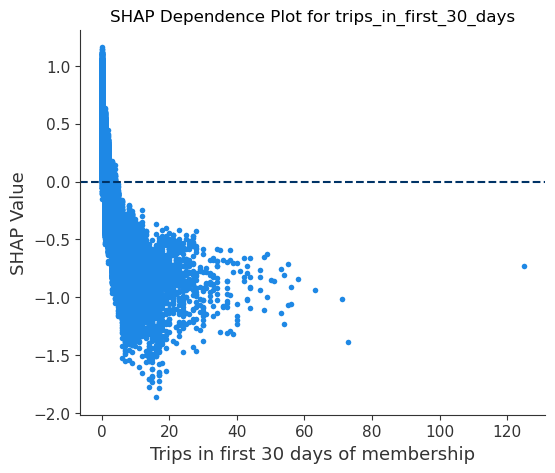

In [78]:
shap.dependence_plot('trips_in_first_30_days', shap_values, X, show = False, interaction_index=None)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line

# Add a title to the plot
ax.set_title('SHAP Dependence Plot for trips_in_first_30_days')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Trips in first 30 days of membership')
ax.set_ylabel('SHAP Value')

# Show the plot
plt.show()

Riders who take more than about 10 trips in the first 30 days see a negative impact on retention
according to the model. Additional research should be done here as well to understand why high engagement 
within the first 30 days leads to less retention at the 6 month mark. 

Conversely, it might be beneficial to offer riders who have high engagement early on some additional incentives to 
stay with the service for a longer period of time. 

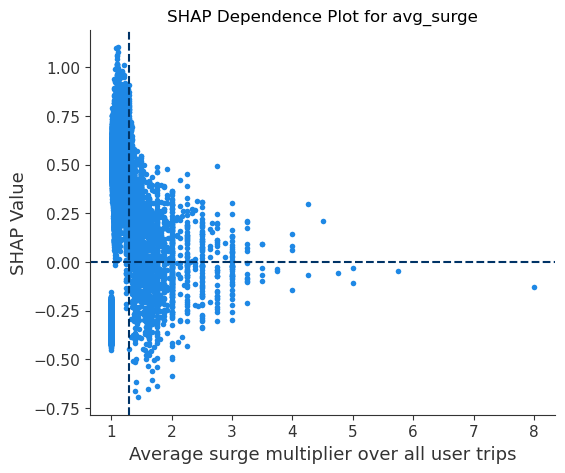

In [94]:
shap.dependence_plot('avg_surge', shap_values, X, show = False, interaction_index=None)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line


# Add a title to the plot
ax.set_title('SHAP Dependence Plot for avg_surge')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Average surge multiplier over all user trips')
ax.set_ylabel('SHAP Value')

# Show the plot
plt.show()

Surge multipliers tend to have a neutral or negative impact on retention above a multiplier of approximately 1.3.

This isn't universal. Even at higher surge multiplier values the impact is mixed. However, it's pretty clear that not paying surge pricing has 
a positive impact on retention. 

## <a id='toc5_4_'></a>[Recommendations](#toc0_)

Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

There are several recommendations that could be made:


1. Attempt to recruit more riders in Kings Landing.
   
2. Target Iphone users for additional marketing and determine why Android use has a negative impact on retention - is the mobile experience worse? 

3. Look at ways to increase Ultimate Black usage during the first 30 days of membership

4. Find ways to make the service appeal to riders on both weekdays and weekends. Riders
who use the service at both times see a positive impact on retention. 

5. Do additional research on riders with high average ratings from drivers. What do they have
   in common? 

6. Look for riders with high early engagement in the platform and take additional steps to keep them on
the platform. High levels of early engagement have a negative impact on long term retention according to the model. 

7. Find ways to reduce surge pricing or make it less obvious. Perhaps a loyalty program that allows a rider 
to avoid surge pricing if they take a certain number of rides per week. Surge pricing can have a negative impact on retention. 